In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import random
pylab.rcParams['figure.figsize'] = (8.0, 10.0)# Import Libraries

# For visualization
import os
import seaborn as sns
from matplotlib import colors
from tensorboard.backend.event_processing import event_accumulator as ea
from PIL import Image

In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
import zipfile
import os

def unzip_folder(zip_file_path, extract_to_folder):
    """
    Unzips a given zip file to the specified folder.

    :param zip_file_path: Path to the zip file to be extracted.
    :param extract_to_folder: Directory where the files should be extracted.
    """
    # Create the target directory if it doesn't exist
    os.makedirs(extract_to_folder, exist_ok=True)

    # Open the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_folder)

    print(f"Extracted {zip_file_path} to {extract_to_folder}")

# Example usage
zip_file_path = '/content/drive/MyDrive/coco.zip'  # Replace with your zip file path
extract_to_folder = '/content/data'  # Replace with your extraction folder path

unzip_folder(zip_file_path, extract_to_folder)


Extracted /content/drive/MyDrive/coco.zip to /content/data


In [4]:
dataDir='/content/data/val'
dataType='COCO_val_annos'
mul_dataType='COCO_mul_val_annos'
annFile='{}/{}.json'.format(dataDir,dataType)
mul_annFile='{}/{}.json'.format(dataDir,mul_dataType)
img_dir = "/content/data/img"

In [5]:
coco=COCO(annFile)
mul_coco=COCO(mul_annFile)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [6]:
#Single Class #Damage dataset
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories for damages: \n{}\n'.format(', '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories for damages: \n{}\n'.format(', '.join(nms)))

#Multi Class #Parts dataset

mul_cats = mul_coco.loadCats(mul_coco.getCatIds())
mul_nms=[cat['name'] for cat in mul_cats]
print('COCO categories for parts: \n{}\n'.format(', '.join(mul_nms)))

mul_nms = set([mul_cat['supercategory'] for mul_cat in mul_cats])
print('COCO supercategories for parts: \n{}\n'.format(', '.join(mul_nms)))

COCO categories for damages: 
damage

COCO supercategories for damages: 
part

COCO categories for parts: 
headlamp, rear_bumper, door, hood, front_bumper

COCO supercategories for parts: 
part



In [7]:
# get all images containing 'damage' category, select one at random
catIds = coco.getCatIds(catNms=['damage']);
imgIds = coco.getImgIds(catIds=catIds );

In [8]:
random_img_id = random.choice(imgIds)
print("{} image id was selected at random from the {} list".format(random_img_id, imgIds))

5 image id was selected at random from the [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] list


In [9]:
# Load the image
imgId = coco.getImgIds(imgIds = [random_img_id])
img = coco.loadImgs(imgId)[0]
print("Image details \n",img)

Image details 
 {'coco_url': '', 'date_captured': '2020-07-14 09:59:34.190485', 'file_name': '42.jpg', 'flickr_url': '', 'height': 1024, 'id': 5, 'license': 1, 'width': 1024}


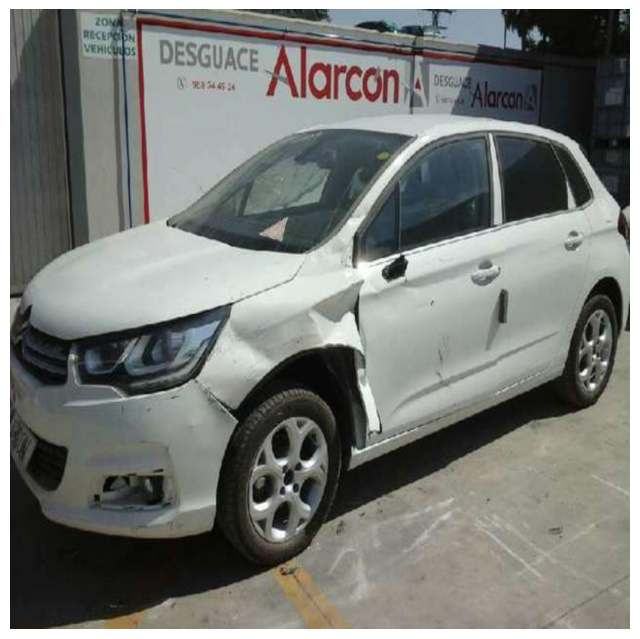

In [10]:
I = io.imread(img_dir + '/' + img['file_name'])
plt.axis('off')
plt.imshow(I)
plt.show()

In [11]:
#get damage annotations
annIds = coco.getAnnIds(imgIds=imgId,iscrowd=None)
anns = coco.loadAnns(annIds)

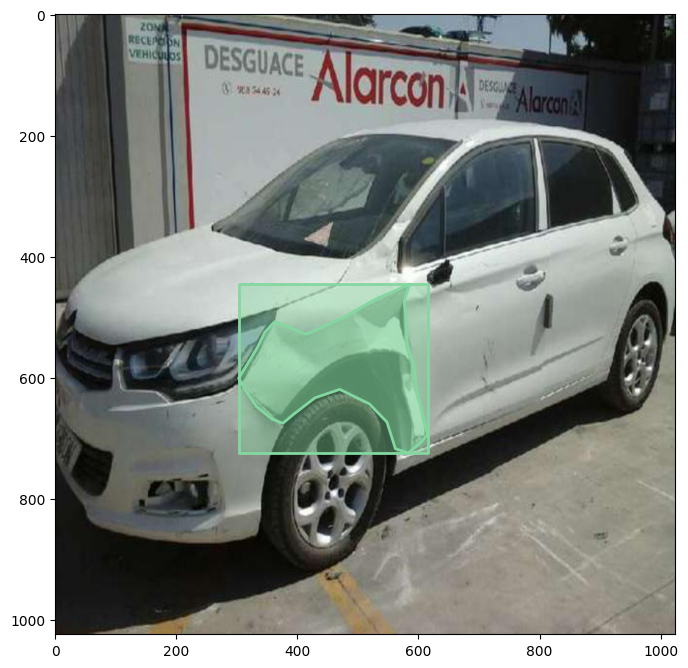

In [12]:
#Plot damages
plt.imshow(I)
plt.axis('on')
coco.showAnns(anns, draw_bbox=True )

In [13]:
#get parts annotations
mul_annIds = mul_coco.getAnnIds(imgIds=imgId,iscrowd=None)
mul_anns = mul_coco.loadAnns(mul_annIds)

In [14]:
# Create a dictionary between category_id and category name
category_map = dict()

for ele in list(mul_coco.cats.values()):
    category_map.update({ele['id']:ele['name']})

In [15]:
category_map


{1: 'headlamp', 2: 'rear_bumper', 3: 'door', 4: 'hood', 5: 'front_bumper'}

Parts are: ['headlamp', 'front_bumper', 'door', 'hood']


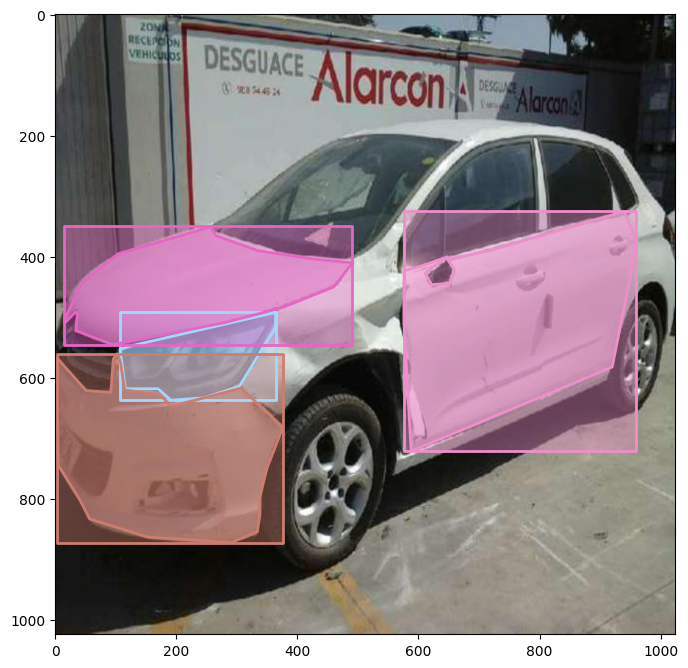

In [16]:
#Create a list of parts in the image
parts = []
for region in mul_anns:
    parts.append(category_map[region['category_id']])

print("Parts are:", parts)

#Plot Parts
I = io.imread(img_dir + '/' + img['file_name'])
plt.imshow(I)
plt.axis('on')
mul_coco.showAnns(mul_anns, draw_bbox=True )

In [17]:
import torchvision.transforms as transforms


# Define transformations for training
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [24]:
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection

# Define paths
dataDir = '/content/data/val'
dataType = 'COCO_val_annos'
mul_dataType = 'COCO_mul_val_annos'

# Annotation files
annFile = os.path.join(dataDir, '{}.json'.format(dataType))
mul_annFile = os.path.join(dataDir, '{}.json'.format(mul_dataType))

# Image directory
img_dir = '/content/data/img'

# Transformations: resize images and apply normalization
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize RGB channels
])

# Load the COCO validation dataset
val_dataset = CocoDetection(root=img_dir, annFile=annFile, transform=transform)

# DataLoader
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Check if data is loaded correctly
for images, targets in val_loader:
    print("Image batch shape:", images[0].shape)  # Should show (3, 128, 128) for the first image
    print("Targets:", targets)  # List of annotations for the images
    break  # Test with one batch first


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Image batch shape: torch.Size([3, 128, 128])
Targets: ([{'area': 26268.00000000003, 'bbox': [364, 143, 190, 490], 'category_id': 1, 'id': 0, 'image_id': 0, 'iscrowd': 0, 'segmentation': [[454, 143, 388, 296, 364, 424, 375, 505, 422, 597, 495, 633, 516, 577, 554, 489, 539, 349, 550, 259, 539, 210, 521, 166, 495, 150]]}, {'area': 29945.000000000007, 'bbox': [391, 622, 172, 202], 'category_id': 1, 'id': 1, 'image_id': 0, 'iscrowd': 0, 'segmentation': [[528, 622, 505, 675, 392, 675, 391, 712, 409, 778, 432, 824, 477, 822, 528, 785, 560, 729, 563, 688, 548, 662, 537, 647]]}], [{'area': 10792.000000000004, 'bbox': [626, 318, 179, 261], 'category_id': 1, 'id': 2, 'image_id': 1, 'iscrowd': 0, 'segmentation': [[626, 326, 673, 318, 730, 337, 765, 370, 798, 406, 803, 440, 797, 466, 797, 491, 805, 522, 794, 579, 784, 543, 777, 505, 761, 468, 730, 423, 700, 388, 668, 363, 644, 349, 632, 339]]}, {'area': 7167.99999999

In [27]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
from torchvision import transforms
import os
from sklearn.metrics import accuracy_score

# Define the CNN model (same as before)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # Adjust size according to input image size
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Hyperparameter tuning grid
learning_rates = [0.1, 0.01, 0.001]
batch_sizes = [16, 32, 64]
optimizers = ['SGD', 'Adam']

# Load COCO Dataset
dataDir = '/content/data/val'
dataType = 'COCO_val_annos'
img_dir = '/content/data/img'
annFile = os.path.join(dataDir, '{}.json'.format(dataType))

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load COCO dataset
train_dataset = CocoDetection(root=img_dir, annFile=annFile, transform=transform)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameter tuning loop
best_accuracy = 0.0
best_params = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        for opt in optimizers:
            print(f"Training with lr={lr}, batch_size={batch_size}, optimizer={opt}")

            # DataLoader with different batch sizes
            train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

            # Initialize model, loss function, and optimizer
            model = SimpleCNN(num_classes=10).to(device)  # Adjust number of classes based on dataset
            criterion = nn.CrossEntropyLoss()

            # Set optimizer
            if opt == 'SGD':
                optimizer = optim.SGD(model.parameters(), lr=lr)
            elif opt == 'Adam':
                optimizer = optim.Adam(model.parameters(), lr=lr)

            # Training loop
            num_epochs = 5  # Use fewer epochs for faster tuning
            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0
                for images, targets in train_loader:
                    images = torch.stack(images).to(device)  # Stack images into a tensor batch
                    labels = torch.tensor([target[0]['category_id'] for target in targets]).to(device)

                    optimizer.zero_grad()
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()

            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

            # Validation (to check accuracy)
            model.eval()
            all_preds = []
            all_labels = []

            with torch.no_grad():
                for images, targets in train_loader:  # Assuming same loader for validation
                    images = torch.stack(images).to(device)
                    labels = torch.tensor([target[0]['category_id'] for target in targets]).to(device)

                    outputs = model(images)
                    _, preds = torch.max(outputs, 1)

                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

            # Calculate accuracy
            accuracy = accuracy_score(all_labels, all_preds)
            print(f"Validation Accuracy: {accuracy:.4f}")

            # Track the best model and hyperparameters
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'lr': lr, 'batch_size': batch_size, 'optimizer': opt}

print(f"Best accuracy achieved: {best_accuracy:.4f} with params: {best_params}")


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Training with lr=0.1, batch_size=16, optimizer=SGD
Epoch [5/5], Loss: 0.0000
Validation Accuracy: 1.0000
Training with lr=0.1, batch_size=16, optimizer=Adam
Epoch [5/5], Loss: 0.0000
Validation Accuracy: 1.0000
Training with lr=0.1, batch_size=32, optimizer=SGD
Epoch [5/5], Loss: 0.0016
Validation Accuracy: 1.0000
Training with lr=0.1, batch_size=32, optimizer=Adam
Epoch [5/5], Loss: 0.0000
Validation Accuracy: 1.0000
Training with lr=0.1, batch_size=64, optimizer=SGD
Epoch [5/5], Loss: 0.0000
Validation Accuracy: 1.0000
Training with lr=0.1, batch_size=64, optimizer=Adam
Epoch [5/5], Loss: 0.0000
Validation Accuracy: 1.0000
Training with lr=0.01, batch_size=16, optimizer=SGD
Epoch [5/5], Loss: 1.6083
Validation Accuracy: 1.0000
Training with lr=0.01, batch_size=16, optimizer=Adam
Epoch [5/5], Loss: 0.0000
Validation Accuracy: 1.0000
Training with lr=0.01, batch_size=32, optimizer=SGD
Epoch [5/5], Loss: 

In [29]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import numpy as np


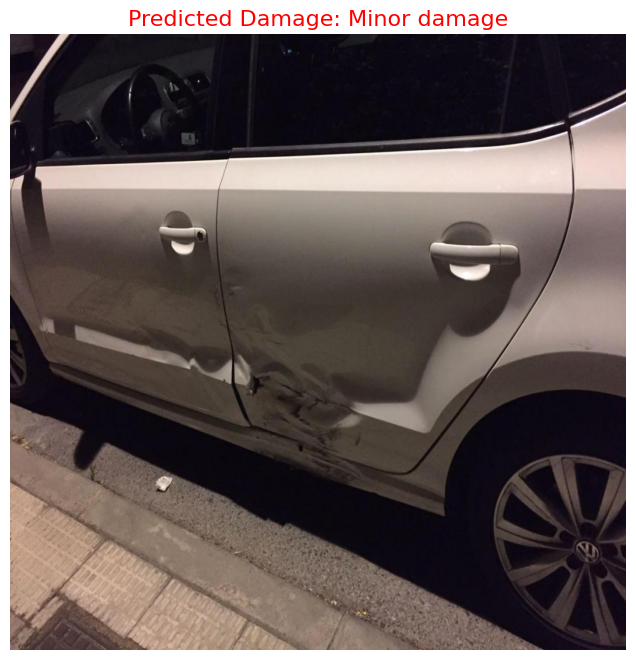

In [32]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T

# Assuming damage classes as per your classification task
damage_classes = ['No damage', 'Minor damage', 'Moderate damage', 'Severe damage']  # Modify as necessary

# Load the trained model (ensure it's in evaluation mode)
model.eval()

# Helper function to plot image and show predicted class
def plot_image_with_prediction(image_path, predicted_label):
    # Open image
    img = Image.open(image_path)

    # Plot the image with title as predicted damage class
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(f'Predicted Damage: {predicted_label}', fontsize=16, color='red')
    plt.axis('off')
    plt.show()

# Preprocessing the image for the model (resize, normalize, etc.)
transform = T.Compose([
    T.Resize((128, 128)),  # Resize to match your model input
    T.ToTensor(),          # Convert to Tensor
])

# Path to an image for damage classification
image_path = '/content/data/img/17.jpg'

# Load and preprocess the image
img = Image.open(image_path)
img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

# Inference using the model
with torch.no_grad():
    output = model(img_tensor.to(device))  # Model prediction (logits)
    probabilities = torch.softmax(output, dim=1)  # Convert logits to probabilities
    predicted_class_idx = probabilities.argmax(dim=1).item()  # Get the predicted class index

# Map the predicted class index to the class label
predicted_label = damage_classes[predicted_class_idx]

# Plot the image with the predicted label
plot_image_with_prediction(image_path, predicted_label)
